In [1]:
!if [ -d deepflows ]; then rm -Rf deepflows; fi
!git clone https://github.com/CDGlissov/recurrent-flows-msc.git deepflows
!pip install "./deepflows"
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import socket
import numpy as np
from torchvision import datasets, transforms
import torch.distributions as td
from deepflows import utils
import numpy as np
import pickle
import time
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid
import IPython
import os
import pandas as pd
from scipy import linalg as la
from math import log, pi, exp
from deepflows.data_generators import stochasticShapes
from deepflows.data_generators import stochasticMovingMnist
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
from torchvision import transforms
import torch.distributions as td
from torch.nn.utils import weight_norm

Cloning into 'deepflows'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 344 (delta 24), reused 0 (delta 0), pack-reused 289
Receiving objects: 100% (344/344), 5.47 MiB | 24.77 MiB/s, done.
Resolving deltas: 100% (183/183), done.
Processing ./deepflows
  Created wheel for recurrent-flows-msc: filename=recurrent_flows_msc-0.1.0-cp36-none-any.whl size=1121 sha256=d92eb47a6648389deb488d8a1477c5880c655c3335ec642ad890f43054975016
  Stored in directory: /tmp/pip-ephem-wheel-cache-qtmow8rs/wheels/f0/5a/77/8518120597d432632c6abe1aa892d29d8c308fccf620551d65
Successfully built recurrent-flows-msc


In [2]:
device = utils.set_gpu(True)
torch.cuda.get_device_name(0)


'Tesla P100-PCIE-16GB'

# Dataloading

Extracting Mnist/MNIST/raw/train-images-idx3-ubyte.gz to Mnist/MNIST/raw


Extracting Mnist/MNIST/raw/train-labels-idx1-ubyte.gz to Mnist/MNIST/raw


Extracting Mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to Mnist/MNIST/raw




Extracting Mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to Mnist/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


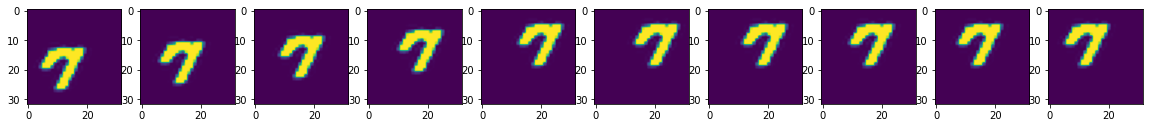

In [3]:
batch_size = 2**5
data_set_type = "mnist"
three_channels=False

if (data_set_type == "shapes"):
  n_frames = 8
  dataset = stochasticShapes.MovingShapes(root_dir = "/content/gdrive/My Drive/movingShapes.h5")
  trainset, valset = torch.utils.data.random_split(dataset, [9000, 1000])

  train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last = True)
  test_loader = DataLoader(valset, batch_size=batch_size, shuffle=True, drop_last = True)
  x_plot = next(iter(train_loader))[0].permute(0,2,3,1)

  fig, ax = plt.subplots(1, n_frames, figsize = (20,5))
  for i in range(n_frames): 
    ax[i].imshow(x_plot[i])
  plt.show()

elif (data_set_type == "mnist"):
  n_frames = 10
  testset = stochasticMovingMnist.MovingMNIST(False, 'Mnist', seq_len=n_frames, image_size=32, digit_size=20, num_digits=1, 
                                              deterministic=False, three_channels=three_channels, step_length=2, normalize=True)
  trainset = stochasticMovingMnist.MovingMNIST(True, 'Mnist', seq_len=n_frames, image_size=32, digit_size=20, num_digits=1, 
                                               deterministic=False, three_channels=three_channels, step_length=2, normalize=True)
  
  train_loader=DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last = True)
  test_loader=DataLoader(testset, batch_size=batch_size, shuffle=False, drop_last = True)
  x_plot = next(iter(train_loader))[0].permute(0,2,3,1)

  if three_channels:
    fig, ax = plt.subplots(1, n_frames, figsize = (20,5))
    for i in range(n_frames): 
      ax[i].imshow(x_plot[i])
    plt.show()
  else:
    fig, ax = plt.subplots(1, n_frames, figsize = (20,5))
    for i in range(n_frames): 
      ax[i].imshow(x_plot[i].view(32,32))
    plt.show()
else:
  print("please specify dataset")



# Init Model

In [4]:

class VRNNConv(nn.Module):
    def __init__(self, x_dim, u_dim, n_layers):
      super(VRNNConv, self).__init__()

      h_dim = 100
      self.h_dim = h_dim
      z_dim = 50
      self.z_dim = z_dim
      x_dim = 32
      self.x_dim = x_dim
      self.beta = 1

      self.n_layers = n_layers
      
      bu, cu, hu, wu = u_dim
      self.u_dim = u_dim
      h, w = utils.get_layer_size([hu, wu], kernels=[3, 3, 3], paddings=[1, 1, 1], strides=[2, 2, 2],
                            dilations=[1, 1, 1])
      
      self.phi_x_t = nn.Sequential(
          nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  #32,32->16,16
          nn.BatchNorm2d(16), 
          nn.ReLU(),
          nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),  #16,16->8,8
          nn.BatchNorm2d(16),
          nn.ReLU(),
        )
      
      self.enc = nn.Sequential( #We need a tighter generalization, make it smaller?
        nn.Conv2d(16 + h_dim, 64,  kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64, 32,  kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        utils.Flatten(),
        nn.Linear(32*8*8, 32*4)
        )
      
      #hu, wu = utils.get_layer_size([self.u_dim[2], self.u_dim[3]], kernels=[3, 3], paddings=[1, 1], strides=[2, 1],dilations=[1, 1])

      self.enc_mean =  nn.Sequential(nn.Linear(32*4, z_dim)) # WORKING HERE
      self.enc_std = nn.Sequential(
        nn.Linear(32*4, z_dim),
        nn.Softplus())


      self.prior = nn.Sequential(utils.Flatten(), 
                                 nn.Linear(h_dim*8*8, h_dim*8),
        nn.LeakyReLU(1/3),
        nn.Linear(h_dim*8, h_dim*8),
        nn.LeakyReLU(1/3),
        )
      self.prior_mean = nn.Linear(h_dim*8, z_dim)
      self.prior_std = nn.Sequential(
        nn.Linear(h_dim*8, z_dim),
        nn.Softplus())


      self.phi_z = nn.Sequential(
        nn.Linear(z_dim, 6*8*8),
        utils.UnFlatten(6, 8, 8),
        nn.LeakyReLU(1/3),
        nn.Conv2d(6, 5,  kernel_size=3, stride=1, padding=1),
        nn.LeakyReLU(1/3),)
      
      
      self.dec = nn.Sequential(
            nn.ConvTranspose2d(h_dim + 5, 64, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64,  kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, output_padding=0), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32,  kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
        )
      
      self.dec_mean = nn.Sequential(nn.ConvTranspose2d(32, 8, kernel_size=1, stride=1, padding=0),nn.ReLU(),nn.Conv2d(8, 1,  kernel_size=3, stride=1, padding=1), nn.Sigmoid())
      self.dec_std = nn.Sequential(nn.ConvTranspose2d(32, 8, kernel_size=1, stride=1, padding=0),nn.ReLU(),nn.Conv2d(8, 1,  kernel_size=3, stride=1, padding=1), nn.Softplus())
      
      self.lstm = nn.LSTM(1344, self.h_dim*8*8, 1)


    def forward(self, xt,predictionToggle):

		  
      kld_loss = 0
      nll_loss =0
      
      ut_features = []
      for i in range(0, xt.shape[1]):
        ut_features.append(self.phi_x_t(xt[:, i, :, :, :]))

      bu, cu, hu, wu = ut_features[0].size()

      h = Variable(torch.zeros( xt.size(0), self.h_dim, hu, wu)).to(device)
      c = Variable(torch.zeros( xt.size(0), self.h_dim, hu, wu)).to(device)

      recons=[]
      prediction=[]
      for i in range(0, xt.shape[1]):
        x = xt[:, i, :, :, :]
        xt_features = ut_features[i]
        

        prior_t = self.prior(h) 
        prior_mean_t = self.prior_mean(prior_t) 
        prior_std_t = self.prior_std(prior_t)


        enc_t = self.enc(torch.cat([h,xt_features], 1))
        enc_mean_t = self.enc_mean(enc_t) 
        enc_std_t = self.enc_std(enc_t)    

        z_t = td.Normal(enc_mean_t, enc_std_t).rsample()
        #print(z_t.shape)
        phi_z_t = self.phi_z(z_t)

        #decoder
        dec_t = self.dec(torch.cat([phi_z_t, h], 1))
        dec_mean_t = self.dec_mean(dec_t)
        dec_std_t = self.dec_std(dec_t)


        Distx=td.Normal(dec_mean_t,dec_std_t)
        recons.append(dec_mean_t.detach())

        
        

        cat_flat = torch.cat([xt_features, phi_z_t], 1).view(bu, -1)
        # Recurrence
        h = h.view(bu, -1).unsqueeze(0)
        c = c.view(bu, -1).unsqueeze(0)
        _, (h, c) = self.lstm(cat_flat.unsqueeze(0), (h, c))
        h = h.view(bu, self.h_dim, hu, wu)
        c = c.view(bu, self.h_dim, hu, wu)


        #computing losses
        kld_loss += self.beta*self._kld_gauss(enc_mean_t, enc_std_t, prior_mean_t, prior_std_t)
        #nll_loss -= Distx.log_prob(x).sum([1,2,3]).mean()
        nll_loss -= self._nll_bernoulli(dec_mean_t, xt[:, i, :])
        
      if predictionToggle==True:
        for i in range(0,10):
          Distx=td.Normal(dec_mean_t,dec_std_t)
          #prediction.append(Distx.sample().detach())
          prediction.append(dec_mean_t.detach())
          xt_features = self.phi_x_t(dec_mean_t)
          prior_t = self.prior(h) 
          prior_mean_t = self.prior_mean(prior_t) 
          prior_std_t = self.prior_std(prior_t)

          z_t = td.Normal(prior_mean_t, prior_std_t).sample()
          #print(z_t.shape)
          phi_z_t = self.phi_z(z_t)

          #decoder
          dec_t = self.dec(torch.cat([phi_z_t, h], 1))
          dec_mean_t = self.dec_mean(dec_t)
          dec_std_t = self.dec_std(dec_t)
          # Recurrence
          cat_flat = torch.cat([xt_features, phi_z_t], 1).view(bu, -1)
          h = h.view(bu, -1).unsqueeze(0)
          c = c.view(bu, -1).unsqueeze(0)
          _, (h, c) = self.lstm(cat_flat.unsqueeze(0), (h, c))
          h = h.view(bu, self.h_dim, hu, wu)
          c = c.view(bu, self.h_dim, hu, wu)
        #prediction.append(Distx.sample().detach())
        prediction.append(dec_mean_t.detach())
        
          




      return kld_loss, nll_loss, recons,prediction

    



    def _nll_bernoulli(self, theta, x):
      loss=torch.sum(x*torch.log(theta) + (1-x)*torch.log(1-theta))
      return loss
    def _kld_gauss(self, mean_1, std_1, mean_2, std_2):
      """Using std to compute KLD"""

      kld_element =  (2 * torch.log(std_2) - 2 * torch.log(std_1) + 
        (std_1.pow(2) + (mean_1 - mean_2).pow(2)) /
        std_2.pow(2) - 1)
    
      return	0.5 * torch.sum(kld_element)



    def reset_parameters(self, stdv=1e-1):
      for weight in self.parameters():
        weight.data.normal_(0, stdv)


Train Epoch: 1 [0/60000 (0%)]	 KLD Loss: 0.003875 	 NLL Loss: 7210.276855


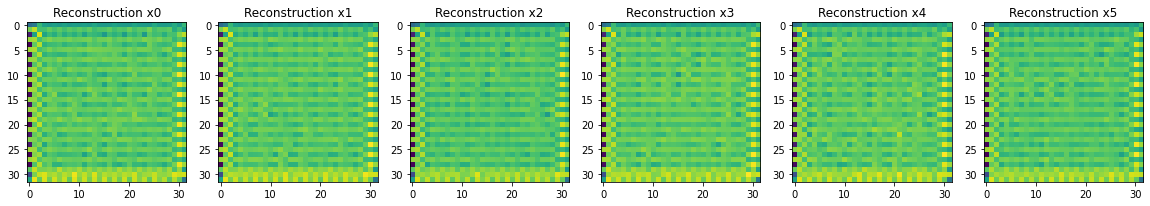

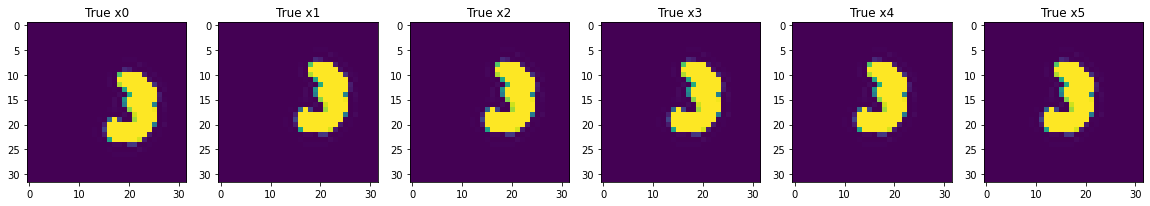

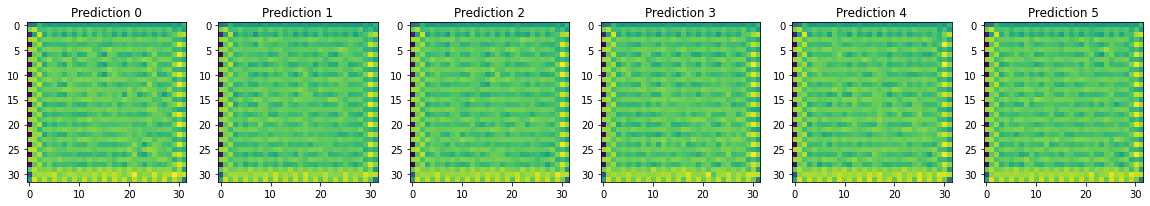

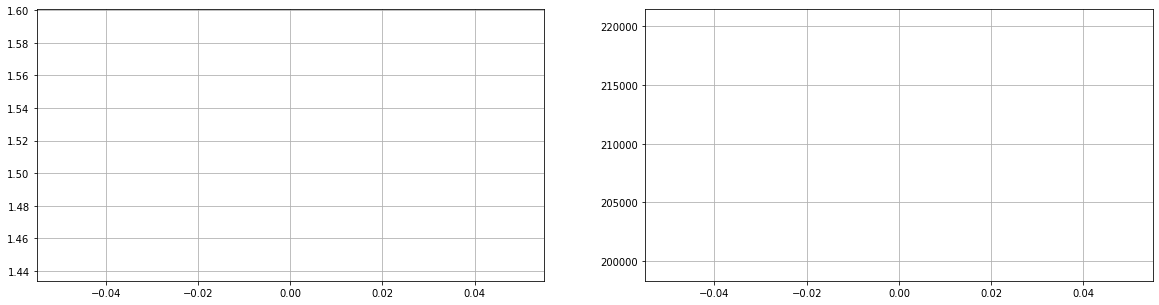

Train Epoch: 1 [12800/60000 (21%)]	 KLD Loss: 37.837784 	 NLL Loss: 711.603271


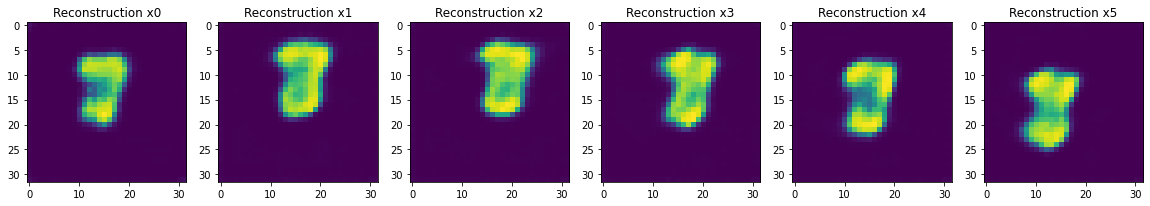

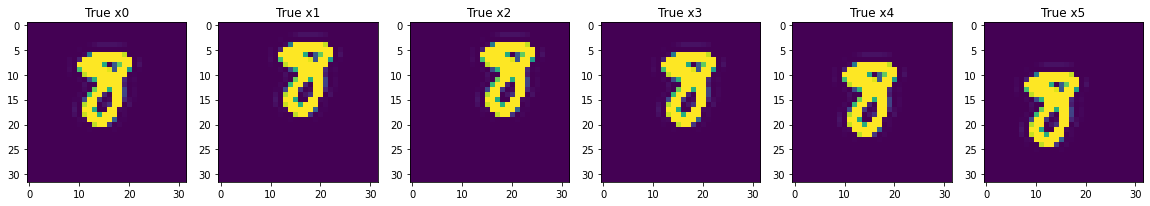

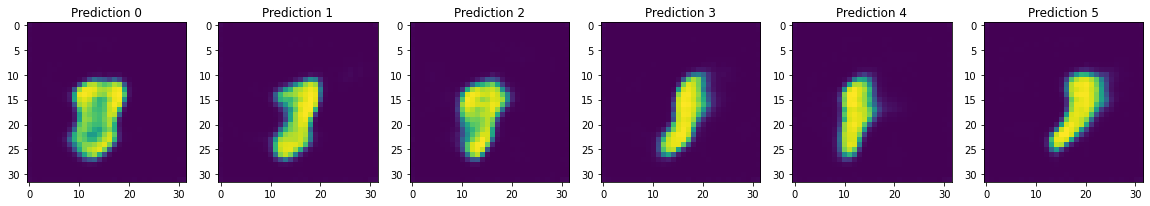

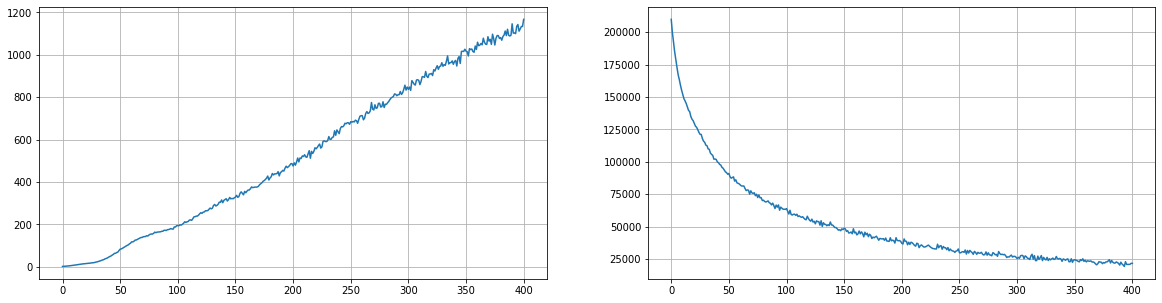

Train Epoch: 1 [25600/60000 (43%)]	 KLD Loss: 61.840004 	 NLL Loss: 514.326477


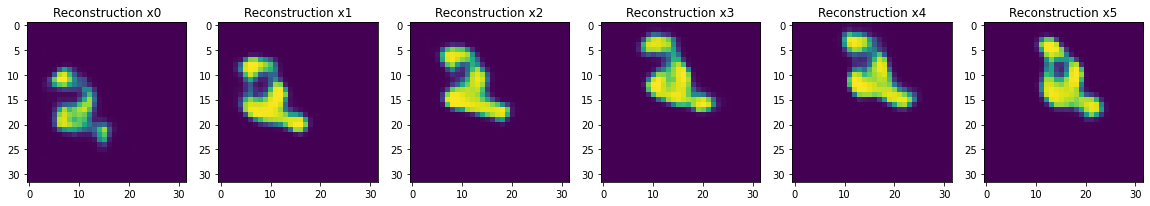

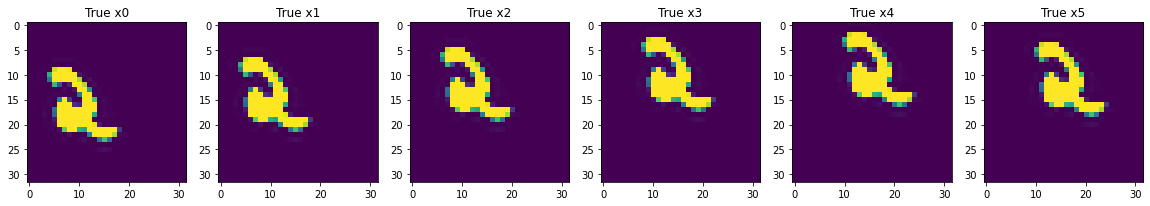

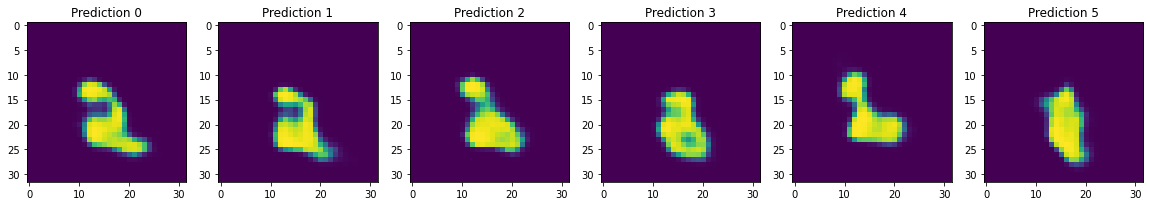

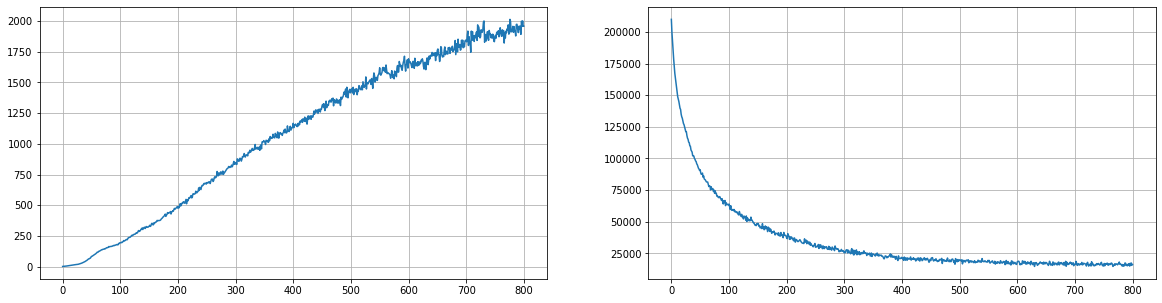

Train Epoch: 1 [38400/60000 (64%)]	 KLD Loss: 71.784271 	 NLL Loss: 445.602112


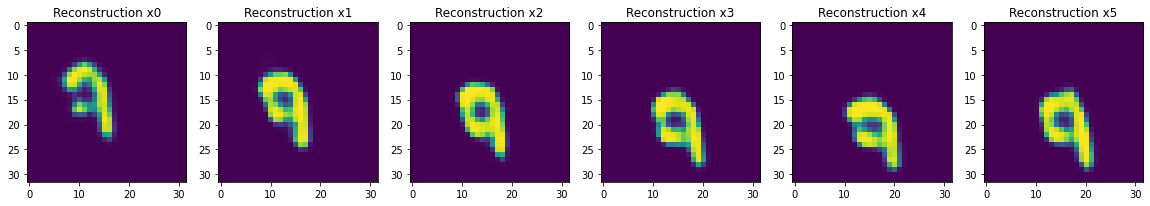

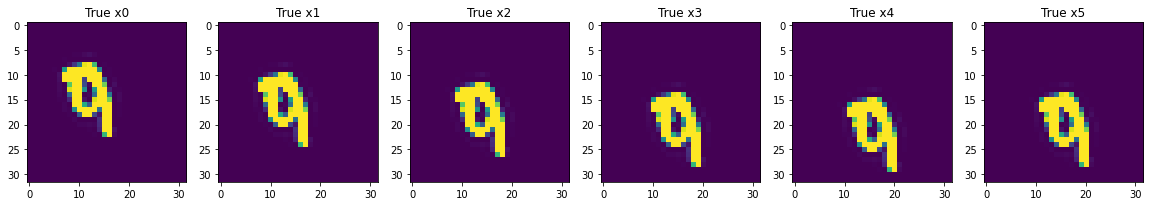

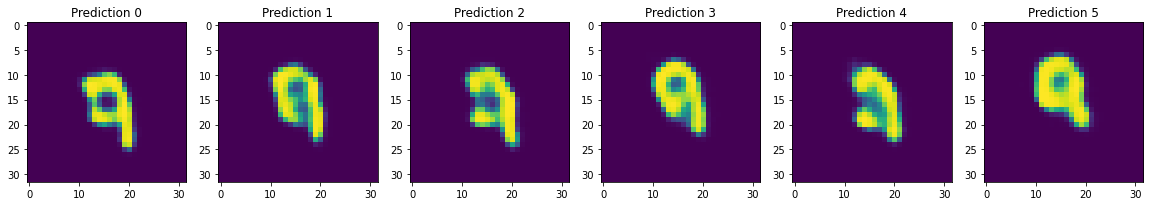

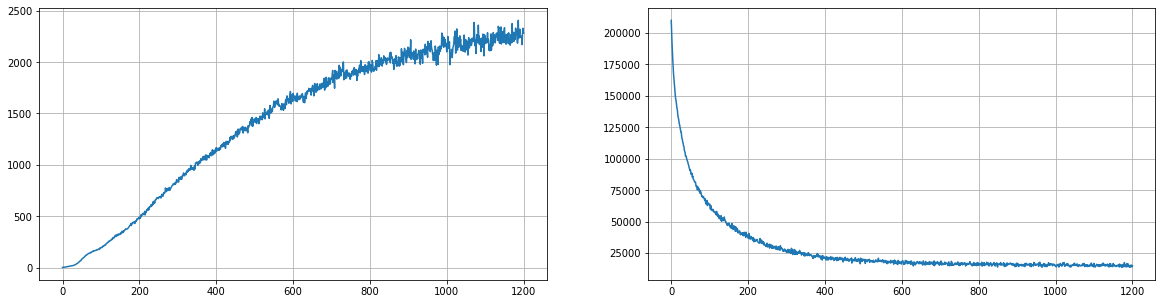

Train Epoch: 1 [51200/60000 (85%)]	 KLD Loss: 81.390343 	 NLL Loss: 473.795258


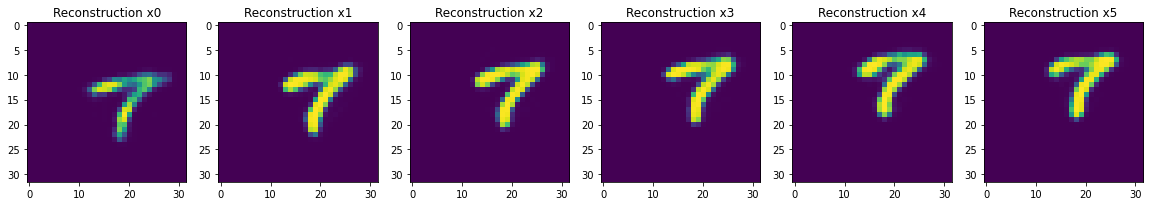

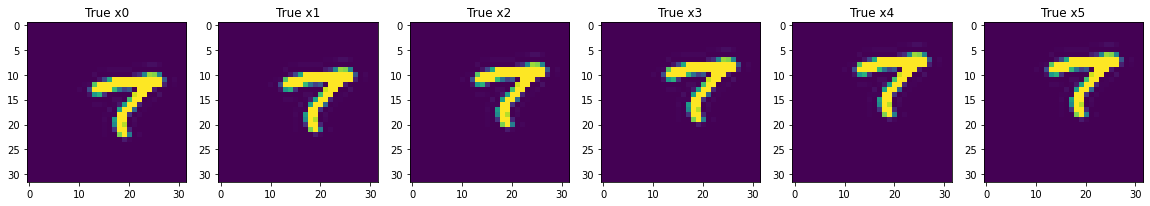

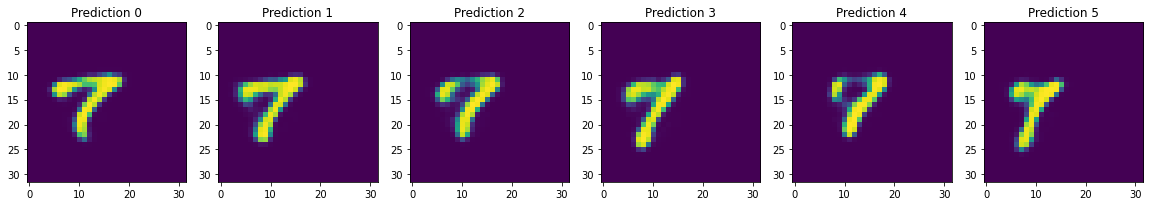

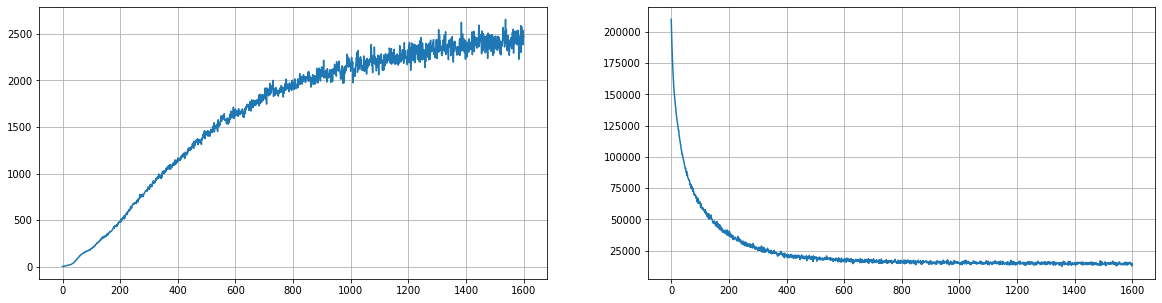

Train Epoch: 2 [0/60000 (0%)]	 KLD Loss: 84.067047 	 NLL Loss: 430.816803


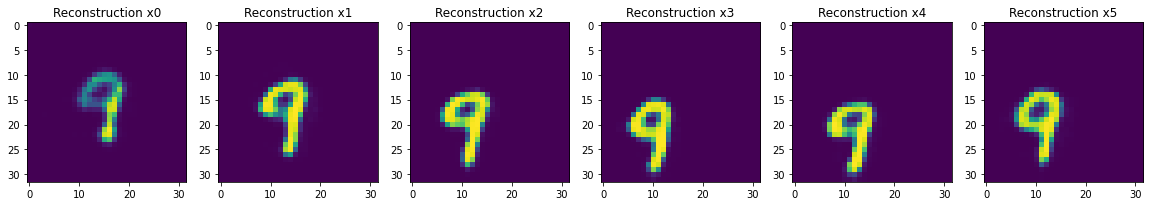

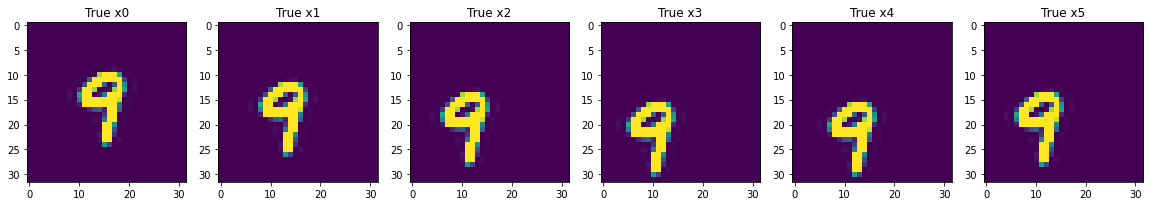

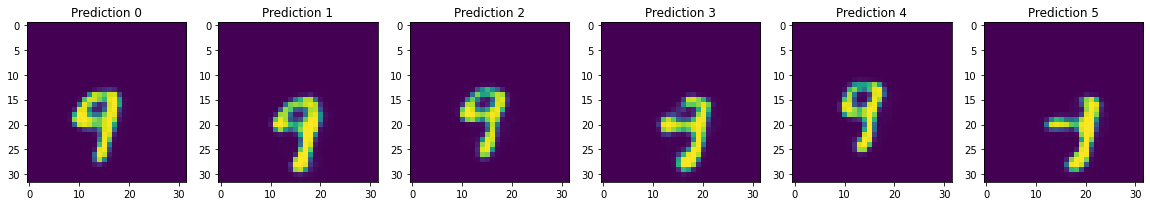

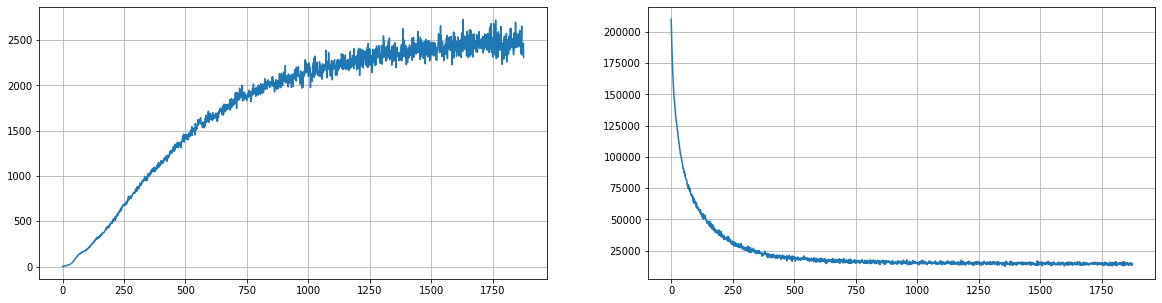

Train Epoch: 2 [12800/60000 (21%)]	 KLD Loss: 90.172340 	 NLL Loss: 474.396332


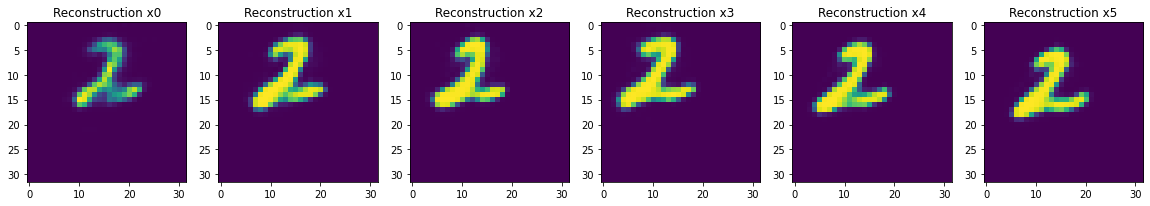

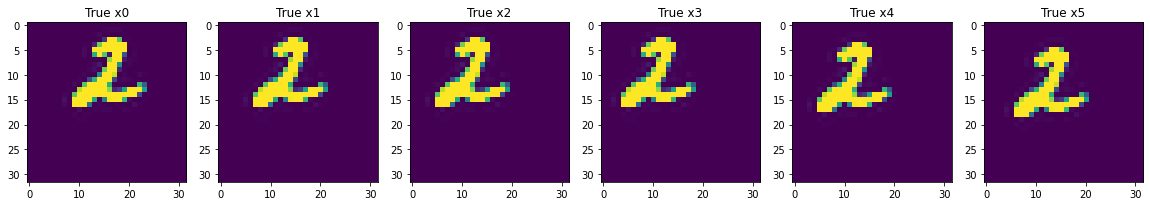

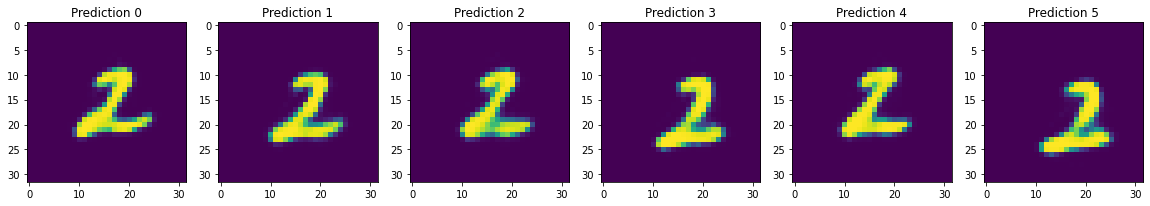

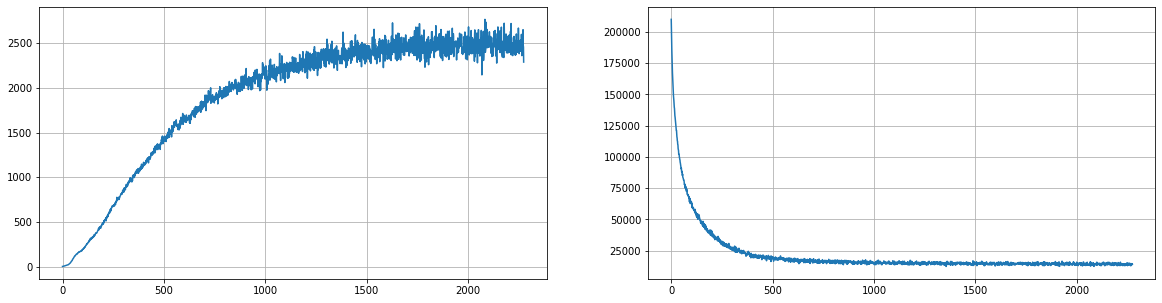

KeyboardInterrupt: ignored

In [6]:

x=next(iter(train_loader))
model = VRNNConv(x_dim = x[:,0,:,:,:].shape, u_dim =x[:,0,:,:,:].shape, n_layers = 1).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
print_every =  400
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor = 0.5)

counter = 0
T_a = len(train_loader)*4
n_epochs = 10
losshis=[]
kldlosshis=[]
nll_losshis=[]
for epoch in range(1, n_epochs + 1):
  train_loss = 0
  for batch_idx, data in enumerate(tqdm(train_loader, desc='Batch', leave=False)):
    #transforming data
    data = data.to(device)
    data = (data - data.min()) / (data.max() - data.min())
    
    # KL Warm up
    model.beta = min(1, 0.001 + (counter+1)/T_a)

    #forward + backward + optimize
    optimizer.zero_grad()
    kld_loss, nll_loss, sample,_ = model(data,False)
    loss = kld_loss + nll_loss
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(),1)
    torch.nn.utils.clip_grad_value_(model.parameters(),0.001)
    losshis.append(loss.detach())
    kldlosshis.append(kld_loss.detach())
    nll_losshis.append(nll_loss.detach())
    optimizer.step()

      
    if batch_idx % print_every == 0:
      with torch.no_grad():
        model.eval()
        data=next(iter(test_loader))
        data = data.to(device)
        data = (data - data.min()) / (data.max() - data.min())
        kld_loss, nll_loss, sample,prediction = model(data,True)
        scheduler.step(loss)
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\t KLD Loss: {:.6f} \t NLL Loss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset),100. * batch_idx / len(train_loader),kld_loss / batch_size,nll_loss / batch_size))
        fig, ax = plt.subplots(1, 6, figsize = (20,5))
        for i in range(0,6):
          ax[i].imshow(sample[i][0].cpu().squeeze(0).numpy())
          ax[i].set_title('Reconstruction x'+str(i))

        fig, ax = plt.subplots(1, 6, figsize = (20,5))
        for i in range(0,6):
          ax[i].imshow(data[0][i].cpu().squeeze(0).numpy())
          ax[i].set_title('True x'+str(i))


        fig, ax = plt.subplots(1, 6, figsize = (20,5))
        for i in range(0,6):
          ax[i].imshow(prediction[i][0].cpu().squeeze(0).numpy())
          ax[i].set_title('Prediction '+str(i))

        fig, ax = plt.subplots(1, 2, figsize = (20,5))
        ax[0].plot(kldlosshis)
        ax[0].grid()
        ax[1].plot(nll_losshis)
        ax[1].grid()
        plt.show()
        model.train()

    counter += 1
    train_loss += loss